In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import backend as K

# the size of the images in the PCAM dataset
IMAGE_SIZE = 96


In [2]:
def get_pcam_generators(base_dir, train_batch_size=32, val_batch_size=32):

     # dataset parameters
     TRAIN_PATH = os.path.join(base_dir, 'train+val', 'train')
     VALID_PATH = os.path.join(base_dir, 'train+val', 'valid')

     RESCALING_FACTOR = 1./255
     
     # instantiate data generators
     datagen = ImageDataGenerator(rescale=RESCALING_FACTOR)

     train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=train_batch_size,
                                             class_mode='input')

     val_gen = datagen.flow_from_directory(VALID_PATH,
                                             target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                             batch_size=val_batch_size,
                                             class_mode='input',
                                             shuffle=False)
     
     return train_gen, val_gen

In [3]:
train_gen, val_gen = get_pcam_generators('../')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [51]:

class autoencoder(Sequential):
    def __init__(self):
        super().__init__()
        self.add(Input(shape=(96,96,3)))

    def create_autoencoder_v1(self, layers = 1):
        for i in range(layers):
            self.add(Conv2D(64, (3,3), activation='relu', padding='same'))
            self.add(MaxPool2D((2,2), padding='same'))

            self.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            self.add(MaxPool2D((2,2), padding='same'))

            self.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            self.add(MaxPool2D((2,2), padding='same'))

            self.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            self.add(UpSampling2D((2,2)))

            self.add(Conv2D(32, (3,3), activation='relu', padding='same'))
            self.add(UpSampling2D((2,2)))
            
            self.add(Conv2D(64, (3,3), activation='relu', padding='same'))
            self.add(UpSampling2D((2,2)))

    def create_autoencoder_v2(self, layers = 1):
        for i in range(layers):
            self.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(96,96,3)))
            self.add(MaxPool2D((2,2), padding='same'))
        
            self.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(96,96,3)))
            self.add(MaxPool2D((2,2), padding='same'))

            self.add(Conv2DTranspose(64, (3,3),strides=2 ,activation='relu', padding='same'))
            self.add(Conv2DTranspose(64, (3,3),strides=2 ,activation='relu', padding='same'))


    def compile_model(self):
        self.add(Conv2D(3, (3,3), activation='sigmoid', padding='same'))
        self.compile(optimizer='adam', loss='mean_squared_error')
    
model1 = autoencoder()
model1.create_autoencoder_v2()
model1.compile_model()
model1._name = 'model1'


In [5]:
train_gen, val_gen = get_pcam_generators('../')

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [52]:
#for layer in model1.layers:
#    print(layer.output_shape)
model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 48, 48, 64)       36928     
 Transpose)                                                      
                                                            

In [53]:
# save the model and weights
model_name = 'my_first_cnn_model'
model_filepath = model_name + '.json'
weights_filepath = model_name + '_weights.hdf5'

model_json = model1.to_json() # serialize model to JSON
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 


# define the model checkpoint and Tensorboard callbacks
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join('logs', model_name))
callbacks_list = [checkpoint, tensorboard]


# train the model
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

history = model1.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=1,
                    shuffle=True,
                    callbacks=callbacks_list)

4500/4500 [==============================] - ETA: 0s - loss: 0.0082
Epoch 1: val_loss improved from inf to 0.00558, saving model to my_first_cnn_model_weights.hdf5
4500/4500 [==============================] - 799s 177ms/step - loss: 0.0082 - val_loss: 0.0056


1/1 [==============================] - 0s 21ms/step


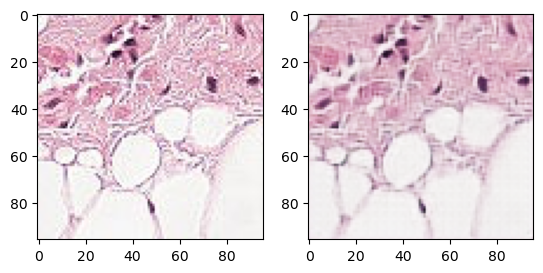

In [94]:
path = "../train+val/valid/0"
names = os.listdir(path)
#true_test = plt.imread(path + "/" + names[6])
predict_test =  model1.predict(train_gen[1][1])
image = 1
fig, ax = plt.subplots(1,2)
ax[0].imshow(train_gen[1][1][image])
ax[1].imshow(predict_test[image])